<a href="https://colab.research.google.com/github/Mastroiani/TCC/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install plotly
!pip install unidecode
!pip install wordcloud
!pip install nltk
!pip install lxml
!pip install graphviz

<h1>
    Bibliotecas
</h1>
<hr>

In [2]:
import pandas as pd
import numpy as np
from unidecode import unidecode

import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

import nltk
from nltk import FreqDist
from string import punctuation
from wordcloud import WordCloud

import plotly.express as px
from IPython.display import Image  
import pydotplus

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from sklearn.externals.six import StringIO  

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



True

<h1>
   Leitura da base de dados .csv e definição do dataframe 'df'
</h1>
<hr>

In [3]:
#definindo lista 'df_list' de arquivos para leitura

path = '/content/drive/MyDrive/DADOSTCC'
df_list = []
for file_name in os.listdir(path):
    df_list.append(pd.read_csv(
        f'{path}/{file_name}',
        sep='@',
        encoding='latin1' # Necessidade de uso desse enconder pela presenca de letras nao lidas pelo UTF-8
    ))


<h3>
    Criando o dataframe 'df', concatenando 'df_list'
</h3>

In [4]:
df = pd.concat(df_list)

if(df.shape[1] > 25):
    df = df.iloc[:,:-1]

print(df.shape)
df.head()

(118589, 25)


,NUMERO DE ORDEM,ANOMES,COD.NCM,DESCRICAO DO CODIGO NCM,PAIS,PAIS DE ORIGEM,PAIS.1,PAIS DE AQUISICAO,UND.ESTAT.,UNIDADE DE MEDIDA,UNIDADE COMERC.,DESCRICAO DO PRODUTO,QTDE ESTATISTICA,PESO LIQUIDO,VMLE DOLAR,VL FRETE DOLAR,VL SEGURO DOLAR,VALOR UN.PROD.DOLAR,QTD COMERCIAL.,TOT.UN.PROD.DOLAR,UNIDADE DESEMBARQUE,UNIDADE DESEMBARACO,INCOTERM,NAT.INFORMACAO,SITUACAO DO DESPACHO
0,962930000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,756,AFRICA DO SUL,756,AFRICA DO SUL,10,QUILOGRAMA LIQUIDO,QUILOGRAMA LIQUIDO,CS215 - FERROMANGANES CONTENDO PESO MAIOR DE 2...,"20000,00000","20000,00000","30190,23","926,59","0,00","1,5510760","20000,00000","31021,5200000",N/INFORMADO,PORTO DO RIO DE JANEIRO,CFR,EFETIVA,DI DESEMBARAÇADA
1,745630000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,INDIA,767,SUICA,10,QUILOGRAMA LIQUIDO,TONEL.METR.LIQ.,PEDIDO: 4512845335 CODIGO ITEM:20001208 FEMNAC...,"360000,00000","360000,00000","354981,62","13999,99","207,13","1015,0000000","360,00000","365400,0000000",N/INFORMADO,PORTO DO RIO DE JANEIRO,CFR,EFETIVA,DI DESEMBARAÇADA
2,745630000200001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,INDIA,767,SUICA,10,QUILOGRAMA LIQUIDO,QUILOGRAMALIQUIDO,FERRO MANGANÊS ALTO CARBONO ...,"45000,00000","45000,00000","44372,71","1749,99","25,89","1,0150000","45000,00000","45675,0000000",N/INFORMADO,PORTO DO RIO DE JANEIRO,CFR,EFETIVA,DI DESEMBARAÇADA
3,1140420000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,INDIA,361,INDIA,10,QUILOGRAMA LIQUIDO,TONELADAMETRICA,FERRO MANGANES ALTO CARBONO --> QUALIDADE QUIM...,"729000,00000","729000,00000","672540,33","31611,76","249,44","960,0000000","729,00000","699840,0000000",N/INFORMADO,ALF - FORTALEZA,CFR,EFETIVA,DI DESEMBARAÇADA
4,233250000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,756,AFRICA DO SUL,756,AFRICA DO SUL,10,QUILOGRAMA LIQUIDO,QUILOGRAMA LIQUIDO,CS215 - FERROMANGANES CONTENDO PESO MAIOR DE 2...,"20000,00000","20000,00000","29497,04","924,46","0,00","1,5162978","20000,00000","30325,9560000",N/INFORMADO,PORTO DO RIO DE JANEIRO,CFR,EFETIVA,DI DESEMBARAÇADA


<h2>Normalizando as colunas de 'df'</h2>
<hr>

In [5]:
#transpõe rótulos das colunas para letras minúsculas e acrescenta "_" entre palavras
df.columns = ["_".join(re.findall(r'\w+',col)).lower() for col in df.columns]

#função 'norm_num': altera caracter "," para "." e "." para ""
def norm_num(num):
    return float(str(num).replace(".","").replace(",","."))

#função 'norm': usa biblioteca de expressões regulares para transpor palavras maiúsculas em minúsculas
def norm(text):
    return " ".join(re.findall(r'\w+',text)).lower()


In [6]:
for column in [
    'qtde_estatistica',
    'peso_liquido',
    'vmle_dolar',
    'vl_frete_dolar',
    'vl_seguro_dolar',
    'valor_un_prod_dolar',
    'qtd_comercial',
    'tot_un_prod_dolar',
    'und_estat'
    ]:
    df[column] = df[column].apply(lambda x: norm_num(x))
    
df['unidade_desembaraco'] = df['unidade_desembaraco'].apply(lambda x: norm(x))
df['pais_de_origem'] = df['pais_de_origem'].apply(lambda x: norm(x))
df['pais_de_aquisicao'] = df['pais_de_aquisicao'].apply(lambda x: norm(x))

df.head()

,numero_de_ordem,anomes,cod_ncm,descricao_do_codigo_ncm,pais,pais_de_origem,pais_1,pais_de_aquisicao,und_estat,unidade_de_medida,unidade_comerc,descricao_do_produto,qtde_estatistica,peso_liquido,vmle_dolar,vl_frete_dolar,vl_seguro_dolar,valor_un_prod_dolar,qtd_comercial,tot_un_prod_dolar,unidade_desembarque,unidade_desembaraco,incoterm,nat_informacao,situacao_do_despacho
0,962930000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,756,africa do sul,756,africa do sul,10.0,QUILOGRAMA LIQUIDO,QUILOGRAMA LIQUIDO,CS215 - FERROMANGANES CONTENDO PESO MAIOR DE 2...,20000.0,20000.0,30190.23,926.59,0.00,1.551076,20000.0,31021.520,N/INFORMADO,porto do rio de janeiro,CFR,EFETIVA,DI DESEMBARAÇADA
1,745630000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,india,767,suica,10.0,QUILOGRAMA LIQUIDO,TONEL.METR.LIQ.,PEDIDO: 4512845335 CODIGO ITEM:20001208 FEMNAC...,360000.0,360000.0,354981.62,13999.99,207.13,1015.000000,360.0,365400.000,N/INFORMADO,porto do rio de janeiro,CFR,EFETIVA,DI DESEMBARAÇADA
2,745630000200001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,india,767,suica,10.0,QUILOGRAMA LIQUIDO,QUILOGRAMALIQUIDO,FERRO MANGANÊS ALTO CARBONO ...,45000.0,45000.0,44372.71,1749.99,25.89,1.015000,45000.0,45675.000,N/INFORMADO,porto do rio de janeiro,CFR,EFETIVA,DI DESEMBARAÇADA
3,1140420000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,india,361,india,10.0,QUILOGRAMA LIQUIDO,TONELADAMETRICA,FERRO MANGANES ALTO CARBONO --> QUALIDADE QUIM...,729000.0,729000.0,672540.33,31611.76,249.44,960.000000,729.0,699840.000,N/INFORMADO,alf fortaleza,CFR,EFETIVA,DI DESEMBARAÇADA
4,233250000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,756,africa do sul,756,africa do sul,10.0,QUILOGRAMA LIQUIDO,QUILOGRAMA LIQUIDO,CS215 - FERROMANGANES CONTENDO PESO MAIOR DE 2...,20000.0,20000.0,29497.04,924.46,0.00,1.516298,20000.0,30325.956,N/INFORMADO,porto do rio de janeiro,CFR,EFETIVA,DI DESEMBARAÇADA


<h1>Separando colunas</h1>
<ul>
    <li>Número de ordem -> ordem, adição e produto</li>
    <li>Ano e mês -> Ano e mês</li>
</ul>
<hr>

In [7]:
numero_de_ordem = df['numero_de_ordem'].copy().astype(str).to_list()
ano_mes = df['anomes'].copy().astype(str).to_list()

In [8]:
adicao = []
produto = []
ordem = []
ano = []
mes = []

for num_ordem, ano_me in zip(numero_de_ordem,ano_mes):
    ordem.append(num_ordem[:-10])
    adicao.append(num_ordem[-10:-5])
    produto.append(num_ordem[-5:])
    ano.append(ano_me[:4])
    mes.append(ano_me[-2:])

In [9]:
df['numero_de_ordem'] = ordem
i = 1
for col in [['adicao',adicao],['produto',produto]]:
    try:
        df.insert(i,col[0],col[1]) # adicionando a coluna adicao
    except:
        print('Coluna ja existente')
    finally:
        i += 1
        
df.insert(3,'ano',ano)
df.insert(4,'mes',mes)

df.drop(['anomes'],axis=1,inplace=True)
df.sort_values(by=['ano'],inplace=True)

In [10]:
df.head(2)

,numero_de_ordem,adicao,produto,ano,mes,cod_ncm,descricao_do_codigo_ncm,pais,pais_de_origem,pais_1,pais_de_aquisicao,und_estat,unidade_de_medida,unidade_comerc,descricao_do_produto,qtde_estatistica,peso_liquido,vmle_dolar,vl_frete_dolar,vl_seguro_dolar,valor_un_prod_dolar,qtd_comercial,tot_un_prod_dolar,unidade_desembarque,unidade_desembaraco,incoterm,nat_informacao,situacao_do_despacho
0,96293,00001,00001,2020,07,72021100,FERROMANGANÊS C/PESO + DE 2% D,756,africa do sul,756,africa do sul,10.0,QUILOGRAMA LIQUIDO,QUILOGRAMA LIQUIDO,CS215 - FERROMANGANES CONTENDO PESO MAIOR DE 2...,20000.0,20000.0,30190.23,926.59,0.00,1.551076,20000.000,31021.520000,N/INFORMADO,porto do rio de janeiro,CFR,EFETIVA,DI DESEMBARAÇADA
1920,59316,00001,00011,2020,11,72123000,OUTS.LAM.PLANOS GALV.P/OUTRO P,607,portugal,607,portugal,10.0,QUILOGRAMA LIQUIDO,Tonelada,"CHAPA LAMINADA PLANA DE ACO, ZINCADA, EM ROLO....",106149.0,106149.0,105185.53,8012.61,34.92,1141.455995,3.364,3839.857968,N/INFORMADO,porto de manaus,CFR,EFETIVA,DI DESEMBARAÇADA


<h1>Verificando dados incompletos (nulos) e redundantes (duplicados)</h1>
<hr>

In [11]:
print(df.isna().sum())
df.dropna(inplace=True)

numero_de_ordem            0
adicao                     0
produto                    0
ano                        0
mes                        0
cod_ncm                    0
descricao_do_codigo_ncm    0
pais                       0
pais_de_origem             0
pais_1                     0
pais_de_aquisicao          0
und_estat                  0
unidade_de_medida          0
unidade_comerc             0
descricao_do_produto       0
qtde_estatistica           0
peso_liquido               0
vmle_dolar                 0
vl_frete_dolar             0
vl_seguro_dolar            0
valor_un_prod_dolar        0
qtd_comercial              0
tot_un_prod_dolar          0
unidade_desembarque        0
unidade_desembaraco        0
incoterm                   0
nat_informacao             0
situacao_do_despacho       0
dtype: int64


In [12]:
df.isnull().sum()

numero_de_ordem            0
adicao                     0
produto                    0
ano                        0
mes                        0
cod_ncm                    0
descricao_do_codigo_ncm    0
pais                       0
pais_de_origem             0
pais_1                     0
pais_de_aquisicao          0
und_estat                  0
unidade_de_medida          0
unidade_comerc             0
descricao_do_produto       0
qtde_estatistica           0
peso_liquido               0
vmle_dolar                 0
vl_frete_dolar             0
vl_seguro_dolar            0
valor_un_prod_dolar        0
qtd_comercial              0
tot_un_prod_dolar          0
unidade_desembarque        0
unidade_desembaraco        0
incoterm                   0
nat_informacao             0
situacao_do_despacho       0
dtype: int64

In [13]:
df.duplicated(['numero_de_ordem','adicao','produto','ano','mes']).sum()

0

<h1>Criando dataframe 'df_filtrado', filtrando atributos de interesse de 'df'</h1>
<hr>
<ul>
    <li>NCM: <strong>72172090</strong></li>
    <li>Natureza Informação: <strong>efetiva</strong></li>
    <li>Situação do Despacho: <strong>di desembaraçada</strong></li>
</ul>

In [14]:
df_filtrado = df[df['cod_ncm'] == 72172090].copy()
df_filtrado['nat_informacao'] = df_filtrado['nat_informacao'].apply(lambda x: norm(x))
df_filtrado['situacao_do_despacho'] = df_filtrado['situacao_do_despacho'].apply(lambda x: norm(x))

df_filtrado = df_filtrado[df_filtrado['nat_informacao'] == 'efetiva']
df_filtrado = df_filtrado[df_filtrado['situacao_do_despacho'] == 'di desembaraçada']

df_filtrado.shape

(1512, 28)

<h1>Agrupando e rateando valores de:</h1>
<ul>
    <li>Peso Liquido</li>
    <li>Valor Frete</li>
    <li>Valor Seguro</li>
    <li>Total Unitário</li>
</ul>
<hr>

In [15]:
grupos_index = df_filtrado['numero_de_ordem'].value_counts().index
grupos_index

Index(['9562', '149237', '51382', '110021', '210283', '173965', '149325',
       '120740', '31021', '18804',
       ...
       '69064', '139286', '17823', '107375', '12697', '36313', '142276',
       '191841', '32707', '132294'],
      dtype='object', length=693)

<h3>Peso Liquido Rataedo e Valor Frete Rateado</h3>

In [16]:
list_aux = [] # objeto auxiliar de armazenamento das variáveis 'peso_liquido_rateado' e 'valor_frete_rateado' que serão criadas abaixo

for grupo in tqdm(grupos_index): #agrupando 'adicao' do mesmo 'numero_de_ordem'
    aux = df_filtrado[df_filtrado['numero_de_ordem'] == grupo].copy() 
    
    sub_grupos_adicao = aux['adicao'].value_counts().index
    
    for sub_adicao in sub_grupos_adicao:  #agrupando produtos da mesmo 'adicao'
        aux_2 = aux[aux['adicao'] == sub_adicao].copy()
        
        qtd_comercial = aux_2['qtd_comercial'] #soma qtd comercial de produtos agrupados por 'numero_de_ordem' e 'adicao'
        soma_qtd_comercial = sum(qtd_comercial)

        
        peso_liquido = aux_2['peso_liquido']
        vl_frete_dolar = aux_2['vl_frete_dolar']
        

        aux_2['peso_liquido_rateado'] = (qtd_comercial/soma_qtd_comercial)*peso_liquido
        aux_2['valor_frete_rateado'] = (qtd_comercial/soma_qtd_comercial)*vl_frete_dolar

        list_aux.append(aux_2)
        
        
df_filtrado = pd.concat(list_aux)
df_filtrado.shape

100%|██████████| 693/693 [00:02<00:00, 261.05it/s]


(1512, 30)

<h3>Seguro Rateado</h3>

In [17]:
list_aux = [] # objeto auxiliar de armazenamento da variáveis 'seguro_rateado'
for grupo in tqdm(grupos_index):
    aux = df_filtrado[df_filtrado['numero_de_ordem'] == grupo].copy()
    
    sub_grupos_adicao = aux['adicao'].value_counts().index
    
    for sub_adicao in sub_grupos_adicao:
        aux_2 = aux[aux['adicao'] == sub_adicao].copy()
        
        total_unitario = aux_2['tot_un_prod_dolar']
        soma_total_unitario = sum(total_unitario)
        

        vl_seguro_dolar = aux_2['vl_seguro_dolar']
        aux_2['seguro_rateado'] = (total_unitario/soma_total_unitario)*vl_seguro_dolar

        list_aux.append(aux_2)
        
        
df_filtrado = pd.concat(list_aux)

100%|██████████| 693/693 [00:02<00:00, 339.18it/s]


In [18]:
df_filtrado.shape

(1512, 31)

<h3>Total Unitario Rateado</h3>
<p>Necessário subtrair 'valor_frete_rateado' e 'seguro_rateado' para INCOTERMS distintos de FOB/FCA/EXW</p>

In [19]:
total_unitario_list = [] # objeto auxiliar de armazenamento da variáveis 'total_unitario_rateado'
for row_ in tqdm(df_filtrado.iloc,total=df_filtrado.shape[0]):
    total_unitario = row_['tot_un_prod_dolar']
    
    if(row_['incoterm'][0] == 'F' or row_['incoterm'][0] == 'E'):
        total_unitario_list.append(total_unitario)
    else:
        total_unitario_list.append(total_unitario - row_['valor_frete_rateado'] - row_['seguro_rateado'])

df_filtrado['total_unitario_rateado'] = total_unitario_list

100%|██████████| 1512/1512 [00:00<00:00, 5569.96it/s]


In [20]:
df_filtrado.shape

(1512, 32)

<h3>Criando Coluna FOB/KG</h3>
<p>Dividindo a coluna calculada <em><strong>total_unitario_rateado</strong></em> pela coluna calculada <em><strong>peso_liquido_rateado</strong></em></p>
<hr>

In [21]:
df_filtrado['fob_kg'] = df_filtrado['total_unitario_rateado']/df_filtrado['peso_liquido_rateado']

<h3>Remoção de unidades comerciais (atributos) não relevantes</h3>
<hr>

<p>Obs.: esse ajuste visa considerar apenas os registros de produtos com unidade comercial relacionada a unidade estatística (Kg)</p> 

In [22]:
df_filtrado['unidade_comerc'] = df_filtrado['unidade_comerc'].apply(lambda x: x.lower())

<p>Verificando as unidades comerciais presentes</p>

In [23]:
freq_unid_com = FreqDist(df_filtrado['unidade_comerc'].values)
freq_unid_com

FreqDist({'12000               ': 1,
          'bobina              ': 37,
          'bobinas             ': 8,
          'caixa               ': 5,
          'caixas              ': 21,
          'carretel            ': 18,
          'kg                  ': 5,
          'kg liquido          ': 1,
          'kilograma           ': 147,
          'kilogramas          ': 12,
          'kilos               ': 1,
          'metro               ': 2,
          'metros              ': 3,
          'metrotoneladas      ': 2,
          'peca                ': 30,
          'pecas               ': 19,
          'peças               ': 2,
          'pé                  ': 1,
          'quiligroma          ': 1,
          'quilo               ': 71,
          'quilograma          ': 80,
          'quilograma liquido  ': 243,
          'quilogramaliqui     ': 1,
          'quilogramaliquido   ': 9,
          'quilogramas         ': 3,
          'quilogramo liqu.    ': 25,
          'quilogrmaliqui

<p>Removendo:</p>
        <ul>
            <li><strong>caixa</strong></li>
            <li><strong>caixas</strong></li>
            <li><strong>carretel</strong></li>
            <li><strong>pacote</strong></li>
            <li><strong>pacotes</strong></li>
            <li><strong>peca</strong></li>
            <li><strong>pecas</strong></li>
            <li><strong>peças</strong></li>
            <li><strong>pé</strong></li>
            <li><strong>rolo</strong></li>
            <li><strong>rolos</strong></li>
            <li><strong>sachet</strong></li>
            <li><strong>sacos</strong></li>
            <li><strong>unidade</strong></li>
            <li><strong>metro</strong></li>
            <li><strong>metros</strong></li>
        </ul>

In [24]:
def search_unid_comer(text):
    
    text = norm(text)
    achou = False
    for comparador in [
        'caixa',
        'caixas',
        'carretel',
        'pacote' ,
        'pacotes' ,
        'peca' ,
        'pecas' ,
        'peças' ,
        'pé',
        'rolo',
        'rolos',
        'sachet' ,
        'sacos' ,
        'unidade' ,
        'metro', # arrumar para tirar somente que for exatamente igual
        'metros' # arrumar para tirar somente que for exatamente igual
        
    ]:
        if(comparador in ['metro','metros']):
            if(text == comparador):
                achou = True
                return False
        elif(re.search(unidecode(comparador),unidecode(text))):
            achou = True
            return False
    if(not achou):
        return text

df_filtrado['unidade_comerc'] = df_filtrado['unidade_comerc'].apply(lambda x: search_unid_comer(x))
df_filtrado = df_filtrado[df_filtrado['unidade_comerc'] != False]

print(df_filtrado.shape)

(1296, 33)


<h3>Descrição do Produto</h3>
<hr>

<p>Obs.: esse ajuste visa considerar apenas os registros de produtos com descrição de produto sem menção de cobertura, pintura e/ou com aplicação especial (óptica)</p>

In [25]:
df_filtrado['descricao_do_produto'] = df_filtrado['descricao_do_produto'].apply(lambda x: x.lower())

# função para remover stopwords e tokenizar
def norm_nltk(text):
    stop_word = nltk.corpus.stopwords.words('portuguese')

    tokens = nltk.word_tokenize(text.lower(),language='portuguese')
    tokens = [token for token in tokens if token not in stop_word]
    tokens = [token for token in tokens if token not in punctuation]

    aux = []
    for token in tokens:
        if(not re.findall(r'[0-9]+',token)):
            aux.append(unidecode(token))
    tokens = aux
    return " ".join(tokens)

df_filtrado['descricao_do_produto'] = df_filtrado['descricao_do_produto'].apply(lambda x: norm_nltk(x))

In [26]:
df_filtrado['descricao_do_produto'].head()

3842    arame aco ligado galvanizado tipo industrial a...
3843    arame aco ligado galvanizado tipo industrial a...
3844    arame aco ligado galvanizado tipo industrial a...
3845    arame aco ligado galvanizado tipo comercial ac...
3846    arame aco ligado galvanizado tipo comercial ac...
Name: descricao_do_produto, dtype: object

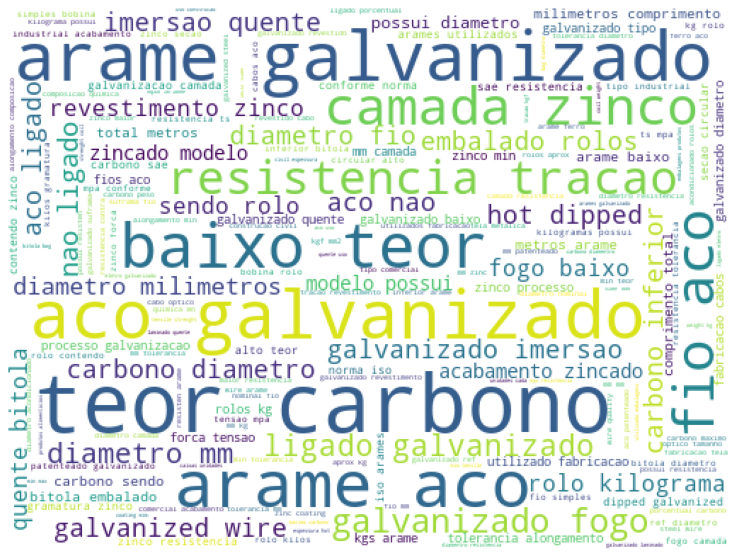

In [27]:
plt.subplots(figsize = (15,10))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(df_filtrado['descricao_do_produto']))
plt.imshow(wordcloud) 
plt.axis('off')
plt.show()

In [28]:
ls_df_filtrado = list(df_filtrado['descricao_do_produto'].values)
str_ls = " ".join(ls_df_filtrado)
#print(str_ls)
palavras=nltk.word_tokenize(str_ls)
freq_desc_prod = FreqDist(palavras)
freq_desc_prod 

FreqDist({"''": 10,
          '**suframa**fio': 27,
          '+-': 59,
          '+/-': 233,
          '+ou': 16,
          '+ou-': 7,
          '-ex': 1,
          '-h': 1,
          '.fio': 3,
          '.t': 8,
          '.te': 1,
          '.teo': 3,
          '.teor': 4,
          '.tolerancia': 6,
          '//': 12,
          '/diametro': 1,
          '1/2': 4,
          '2': 2,
          '?': 6,
          '``': 5,
          'aao': 1,
          'abaixo': 4,
          'abnt': 2,
          'acabamento': 120,
          'acer': 4,
          'achatado': 1,
          'acima': 17,
          'aco': 955,
          'acomodados': 2,
          'acondicionado': 44,
          'acondicionados': 42,
          'acsr': 2,
          'ada': 1,
          'aeo': 2,
          'agropecuario': 1,
          'agrupados': 5,
          'ai': 2,
          'ajax': 4,
          'al': 5,
          'alam': 3,
          'alambrados': 7,
          'alambrados.forma': 12,
          'alambre': 1,
          'aliment

<p>Removendo produtos de descrição com palavras verificadas como não relevantes:</p>
        



In [29]:
def search_desc_prod(text):
    text = text.lower()
    achou = False
    for comparador in [
            'aluminio',
            'aluminio-liga',
            'plastico',
            'plasticos',
            'plasticos.utilizacao',
            'pvc',
            'policloreto',
            'polietileno',
            'polimericos',
            'polimeros',
            'polipropileno',
            'vinila',
            'preto',
            'prata',
            'branca',
            'branco',
            'verde',
            'azul',
            'brilho',                     
            'otica',
            'optico',
            'optica',
            'mascara',
            'mascaras',
            'mask',
            'laca'            
        ]:
        
        if(re.search(unidecode(comparador),unidecode(text))):
            achou = True
            return False
    if(not achou):
        return text

df_filtrado['descricao_do_produto'] = df_filtrado['descricao_do_produto'].apply(lambda x: search_desc_prod(x))
df_filtrado = df_filtrado[df_filtrado['descricao_do_produto'] != False]

<h3>Tamanho do DataFrame final</h3>
<hr>

In [30]:
df_filtrado.shape

(1167, 33)

<h1>Comparando valor FOB/KG com valor de cotação mensal internacional da matéria-prima (Wire Rod - Fio Máquina)</h1>
<hr>

<h3>Leitura dos dados de cotação da página web de referência</h3>

In [31]:
URL = 'https://mepsinternational.com/gb/en/products/world-steel-prices'

df_wire_rod = pd.read_html(URL,match='Wire Rod')[0]
df_wire_rod

,Month,Hot Rolled Coil,Hot Rolled Plate,Cold Rolled Coil,Hot Dipped Galvanised Coil,Electro Zinc Coated Coil,Wire Rod,Sections & Beams,Rebar,Merchant Bar
0,Jul-2020,517.0,573.0,624.0,728.0,756.0,548.0,656.0,524.0,615.0
1,Aug-2020,531.0,580.0,633.0,738.0,764.0,555.0,668.0,536.0,623.0
2,Sep-2020,591.0,605.0,694.0,804.0,823.0,578.0,679.0,555.0,632.0
3,Oct-2020,638.0,620.0,741.0,853.0,870.0,587.0,693.0,563.0,647.0
4,Nov-2020,671.0,630.0,780.0,890.0,901.0,602.0,696.0,567.0,651.0
5,Dec-2020,766.0,699.0,874.0,982.0,994.0,637.0,728.0,609.0,688.0
6,Jan-2021,924.0,847.0,1022.0,1134.0,1143.0,772.0,884.0,738.0,815.0
7,Feb-2021,968.0,885.0,1091.0,1203.0,1215.0,798.0,907.0,741.0,828.0
8,Mar-2021,1033.0,933.0,1156.0,1271.0,1281.0,805.0,919.0,752.0,840.0
9,Apr-2021,1129.0,999.0,1254.0,1372.0,1386.0,806.0,918.0,756.0,836.0


<h3>Definindo dataframe 'df_wire_rod'</h3>

In [32]:
df_wire_rod = df_wire_rod[['Month','Wire Rod']].copy().dropna()
df_wire_rod['Wire Rod'] = df_wire_rod['Wire Rod'].apply(lambda x: x/1000)
df_wire_rod

,Month,Wire Rod
0,Jul-2020,0.548
1,Aug-2020,0.555
2,Sep-2020,0.578
3,Oct-2020,0.587
4,Nov-2020,0.602
5,Dec-2020,0.637
6,Jan-2021,0.772
7,Feb-2021,0.798
8,Mar-2021,0.805
9,Apr-2021,0.806


In [33]:
#exportando 'df_wire_rod' em formato csv
df_wire_rod.to_csv('/content/drive/MyDrive/wire_rod.csv',index=False)

<h3>Visualização gráfica da evolução da cotação do Wire Rod</h3>

In [34]:
fig = px.line(
    df_wire_rod,
    x="Month", 
    y="Wire Rod", 
    title="Variação do Wire Rod",
    text='Wire Rod'
)
fig.update_traces(textposition="bottom right")
fig.show()

<h3>Comparação</h3>
<p>Comparação do <strong>valor FOB/KG do produto manufaturado</strong> com o valor de <strong> cotação mensal internacional da matéria-prima (Wire Rod)</strong>; visa identificar se existe incompatibilidade de valor declarado (1 - True) ou não (0 - False)</p>

In [35]:
map_mes = {
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
    }

In [36]:
aux = []
wire_rod_list = []
for row_ in df_filtrado.iloc:
    
    try:
        wire_rod = df_wire_rod[df_wire_rod['Month'] == f"{map_mes[row_['mes']]}-{row_['ano']}"]['Wire Rod'].values[0]
        wire_rod_list.append(wire_rod)
        if(row_['fob_kg'] < wire_rod):
            aux.append(1)
        else:
            aux.append(0)
    except:
        aux.append(None)
        wire_rod_list.append(None)
        
df_filtrado['cotacao'] = wire_rod_list
df_filtrado['incompatibil'] = aux

In [37]:
df_filtrado.shape

(1167, 35)

<h1>Visualização dos dados</h1>
<hr>

In [38]:
df_filtrado.reset_index(inplace=True,drop=True)

expo_df = df_filtrado[[
    'numero_de_ordem',
    'adicao',
    'produto',
    'ano',
    'mes',
    'pais_de_origem',
    'unidade_desembaraco',
    'pais_de_aquisicao',
    'peso_liquido',
    'qtd_comercial',
    'vl_frete_dolar',
    'vl_seguro_dolar',
    'tot_un_prod_dolar',
    'peso_liquido_rateado',
    'valor_frete_rateado',
    'seguro_rateado',
    'total_unitario_rateado',
    'fob_kg',
    'cotacao',
    'incompatibil'
]]
expo_df['incompatibil'] = expo_df['incompatibil'].apply(lambda x: 'Sim' if x == 1 else 'Nao')
expo_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,numero_de_ordem,adicao,produto,ano,mes,pais_de_origem,unidade_desembaraco,pais_de_aquisicao,peso_liquido,qtd_comercial,vl_frete_dolar,vl_seguro_dolar,tot_un_prod_dolar,peso_liquido_rateado,valor_frete_rateado,seguro_rateado,total_unitario_rateado,fob_kg,cotacao,incompatibil
0,149237,00001,00009,2021,02,china republica pop,itajai,china republica pop,258833.0,9000.0,53500.0,352.48,6624.000,9000.0,1860.272840,11.218297,6624.000,0.736,0.798,Sim
1,149237,00001,00010,2021,02,china republica pop,itajai,china republica pop,258833.0,26000.0,53500.0,352.48,20072.000,26000.0,5374.121538,33.993608,20072.000,0.772,0.798,Sim
2,149237,00001,00011,2021,02,china republica pop,itajai,china republica pop,258833.0,15000.0,53500.0,352.48,12675.000,15000.0,3100.454733,21.466171,12675.000,0.845,0.798,Nao
3,149237,00001,00012,2021,02,china republica pop,itajai,china republica pop,258833.0,35.0,53500.0,352.48,34.475,35.0,7.234394,0.058386,34.475,0.985,0.798,Nao
4,149237,00001,00013,2021,02,china republica pop,itajai,china republica pop,258833.0,19.0,53500.0,352.48,19.095,19.0,3.927243,0.032339,19.095,1.005,0.798,Nao


In [39]:
print(expo_df.isna().sum())

numero_de_ordem           0
adicao                    0
produto                   0
ano                       0
mes                       0
pais_de_origem            0
unidade_desembaraco       0
pais_de_aquisicao         0
peso_liquido              0
qtd_comercial             0
vl_frete_dolar            0
vl_seguro_dolar           0
tot_un_prod_dolar         0
peso_liquido_rateado      0
valor_frete_rateado       0
seguro_rateado            0
total_unitario_rateado    0
fob_kg                    0
cotacao                   0
incompatibil              0
dtype: int64


In [40]:
expo_df[expo_df['cotacao'].isna()]

,numero_de_ordem,adicao,produto,ano,mes,pais_de_origem,unidade_desembaraco,pais_de_aquisicao,peso_liquido,qtd_comercial,vl_frete_dolar,vl_seguro_dolar,tot_un_prod_dolar,peso_liquido_rateado,valor_frete_rateado,seguro_rateado,total_unitario_rateado,fob_kg,cotacao,incompatibil


In [41]:
!pip install plotly

In [42]:
import plotly.express as px
fig = px.scatter(expo_df,x='fob_kg', y='peso_liquido')#color='incompatibil')

fig.show()

In [43]:
import plotly.express as px
fig = px.scatter(expo_df,x='unidade_desembaraco', y='pais_de_origem',color='incompatibil')
fig.show()

<h1>Nota</h1>
<p>Reduzimos a proporção dos dados através do <strong>Logarítmico</strong>, uma técnica usada para melhor visualização dos dados</p>

In [44]:
import plotly.graph_objects as go

for year in ['2020','2021']:
    medias = []


    df_2021 = df_filtrado[df_filtrado['ano'] == year]
    mes_grupos = df_2021['mes'].value_counts().index
    for mes_grup in mes_grupos:
        medias.append([mes_grup,df_2021[df_2021['mes'] == mes_grup]['fob_kg'].to_list()])

    medias = sorted(medias,key=lambda x: x[0])
    
    fig = go.Figure()
    for x in medias:
        fig.add_trace(go.Box(y=[np.log2(y) for y in x[1]],name=map_mes[x[0]]))

    fig.update_layout(
        title=go.layout.Title(
            text=f"Análise durante o ano de {year}",
            xref="paper",
            x=0
        )
        )

    fig.show()

In [45]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Países de origem <br><sup>Produtos com valor declarado incompatível",
        xref="paper",
        x=0
    )
    )
fig.show()

In [46]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [47]:
info_pais_origem = df_filtrado['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Países de origem <br><sup>Todos Produtos",
        xref="paper",
        x=0
    )
    )
fig.show()

In [48]:
info_pais_origem = df_filtrado['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [92]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_aquisicao'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="País de Aquisição<br><sup>Produtos com valor declarado incompatível</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [88]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [91]:
info_pais_origem = df_filtrado['pais_de_aquisicao'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="País de Aquisição<br><sup>Todos Produtos</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [90]:
info_pais_origem = df_filtrado['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [86]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['unidade_desembaraco'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Unidade de desembaraço<br><sup>Produtos com valor declarado incompatível</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [87]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['unidade_desembaraco'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [95]:
info_pais_origem = df_filtrado['unidade_desembaraco'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Unidade de desembaraço<br><sup>Todos Produtos</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [96]:
info_pais_origem = df_filtrado['unidade_desembaraco'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

<h3>Exportando tabela em formato .csv</h3>

In [51]:
path = '/content/drive/MyDrive'
name = 'dataset_preprocessado_TCC'

if(not os.path.exists(path)):
    os.mkdir(path)

df_filtrado.to_csv(f'{path}/{name}',index=False)

<h1>Importando tabela exportada</h1>
<hr>

In [52]:
path = '/content/drive/MyDrive'
name = 'dataset_preprocessado_TCC'

df = pd.read_csv(f'{path}/{name}')

df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
df.shape

(1167, 35)

<h3>Transformando atributo 'unidade_desembaraço' em variáveis numéricas</h3>

In [53]:
#Transformando atributo 'unidade_desembaraço' em variáveis numéricas
map_portos = {porto:num for num,porto in enumerate(df['unidade_desembaraco'].value_counts().index)}

df['unidade_desembaraco'] = df['unidade_desembaraco'].apply(lambda x: map_portos[x])

<h1>Machine Learning - Desenvolvimento dos Modelos</h1>
<hr>
<h2>Treinamento</h2>
<h3>Colunas usadas para o treinamento</h3>
<ul>
    <li>País de Origem</li>
    <li>País de Aquisição</li>
    <li>Unidade Desembaraco</li>
    <li>Quantidade Estatística</li>
    <li>Peso líquido</li>
    <li>Vmle</li>
    <li>Frete</li>
    <li>Seguro</li>
    <li>Produção</li>
    <li>Quantidade comercial</li>
<ul>

In [54]:
#definindo variáves usadas no treinamento (X) e variável target (y)

#X = df[['pais','pais_1','unidade_desembaraco']]
X = df[['pais','pais_1','unidade_desembaraco',
       'qtde_estatistica',
       'vmle_dolar',
       'vl_frete_dolar',
       'vl_seguro_dolar',
       'valor_un_prod_dolar',
       'qtd_comercial',
       'tot_un_prod_dolar',
       'peso_liquido_rateado',
       'valor_frete_rateado',
       'seguro_rateado',
       'total_unitario_rateado',
       'fob_kg'
       ]]

y = df[['incompatibil']]#['abaixo_fob_kg']

i_CV = 10

In [55]:
X.describe()

,pais,pais_1,unidade_desembaraco,qtde_estatistica,vmle_dolar,vl_frete_dolar,vl_seguro_dolar,valor_un_prod_dolar,qtd_comercial,tot_un_prod_dolar,peso_liquido_rateado,valor_frete_rateado,seguro_rateado,total_unitario_rateado,fob_kg
count,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000
mean,333.984576,350.710368,1.838903,63820.881448,54594.095476,9932.194293,93.538063,514.500425,8501.709973,20299.297536,22263.576507,2865.199463,33.350096,19469.919713,1.678634
std,283.218166,282.085589,2.779136,57450.037732,47414.227832,16863.065897,146.792824,516.419590,17766.790836,22308.065036,24148.367790,4903.510085,64.097609,21550.380847,23.505218
min,23.000000,23.000000,0.000000,8.000000,296.120000,11.150000,0.000000,0.218700,0.080000,17.200000,1.048530,0.043195,0.000000,17.200000,0.079966
25%,160.000000,160.000000,0.000000,25000.000000,22318.770000,1094.500000,0.000000,0.913500,14.275000,4929.800000,5375.400000,311.154820,0.000000,4823.585424,0.755047
50%,160.000000,160.000000,1.000000,50000.000000,38878.140000,3200.000000,30.390000,700.000000,50.379000,15000.000000,17652.000000,975.000000,7.080000,14395.250423,0.856045
75%,386.000000,741.000000,2.000000,80305.000000,69807.790000,9900.000000,124.495000,877.000000,10500.000000,25789.500203,26000.000000,3301.799142,36.412458,24656.390184,0.995000
max,845.000000,845.000000,17.000000,258833.000000,209807.370000,80550.000000,1088.350000,2600.000000,200000.000000,188908.400000,200000.000000,53466.000000,705.990000,180807.070000,800.167800


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 64)

In [57]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(816, 15) (351, 15) (816, 1) (351, 1)


In [58]:
import matplotlib.pyplot as plt

def train_model(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    prec = precision_score (y_test, pred)
    recall = recall_score(y_test, pred,average='binary')
    f1 = f1_score(y_test, pred)
    
    cm = confusion_matrix(y_test, pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[0,1])
    print(f'Acurácia: {round(acc,4)}\nPrecision: {round(prec,4)}\nRevocação: {round(recall,4)}\nF1 Score: {round(f1,4)}')
    #disp.('/content/drive/MyDrive/model.png')
    disp.plot()
    plt.savefig('/content/drive/MyDrive/model.png')
    plt.show()

<h3>Máquina Suporte de Vetores</h3>

Acurácia: 0.8091
Precision: 0.7391
Revocação: 0.2179
F1 Score: 0.3366


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



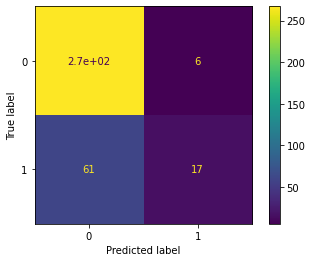

In [59]:
ml_SVC = SVC()

train_model(ml_SVC)

<h3>Naive Bayes</h3>

In [60]:
ml_GNB = CategoricalNB()

train_model(ml_GNB)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



IndexError: ignored

<h3>Árvore de decisão</h3>

Acurácia: 0.9316
Precision: 0.8068
Revocação: 0.9103
F1 Score: 0.8554


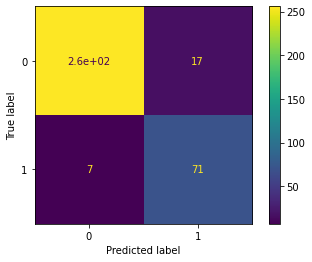

'TreeDecision.pdf'

In [75]:
ml_DT = DecisionTreeClassifier(random_state=64)

train_model(ml_DT)

from sklearn import tree
import graphviz 

dot_data = tree.export_graphviz(ml_DT, 
                                out_file=None,
                                class_names=np.array(['Compatível','Incompatível']),
                                feature_names=X.columns)
graph = graphviz.Source(dot_data)
graph.render("TreeDecision")

In [76]:
y_pred = ml_DT.predict(X_test)
y_pred

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [77]:
print(np.array(y['incompatibil'].to_list()))

[1 1 0 ... 0 0 0]


In [78]:
ml_DT

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=64, splitter='best')

In [79]:
ml_DT_a_scores_CV = cross_val_score(ml_DT, X_train, y_train, cv = 10)
print(f'Média das Acurácias calculadas pelo CV....: {100*round(ml_DT_a_scores_CV.mean(),4)}')
print(f'std médio das Acurácias calculadas pelo CV: {100*round(ml_DT_a_scores_CV.std(),4)}')
ml_DT_a_scores_CV

Média das Acurácias calculadas pelo CV....: 89.09
std médio das Acurácias calculadas pelo CV: 1.7000000000000002


array([0.90243902, 0.87804878, 0.87804878, 0.90243902, 0.87804878,
       0.92682927, 0.88888889, 0.86419753, 0.90123457, 0.88888889])

In [66]:
from time import time

In [67]:
import seaborn as sns

In [68]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

In [69]:
def mostra_confusion_matrix(cf, 
                            group_names = None, 
                            categories = 'auto', 
                            count = True, 
                            percent = True, 
                            cbar = True, 
                            xyticks = False, 
                            xyplotlabels = True, 
                            sum_stats = True, 
                            figsize = (8, 8), 
                            cmap = 'Blues'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

In [70]:
def GridSearchOptimizer(modelo, ml_Opt, d_hiperparametros, X_train, y_train, X_test, y_test, i_CV):
    ml_GridSearchCV = GridSearchCV(modelo, d_hiperparametros, cv = i_CV, n_jobs = -1, verbose= 10, scoring = 'accuracy')
    start = time()
    ml_GridSearchCV.fit(X_train, y_train)
    tempo_elapsed = time()-start
    print(f"\nGridSearchCV levou {tempo_elapsed:.2f} segundos.")

    # Hiperparâmetros que otimizam a classificação:
    print(f'\nHiperparâmetros otimizados: {ml_GridSearchCV.best_params_}')

    if ml_Opt == 'ml_DT2':
      print(f'\nDecisionTreeClassifier *********************************************************************************************************')
      ml_Opt = DecisionTreeClassifier(criterion= ml_GridSearchCV.best_params_['criterion'], 
                                    max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                    max_leaf_nodes= ml_GridSearchCV.best_params_['max_leaf_nodes'],
                                    min_samples_split= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                    min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_split'], 
                                    random_state= 64)

      
    # Treina novamente usando os hiperparâmetros otimizados...
    ml_Opt.fit(X_train, y_train)

    # Cross-Validation com 10 folds
    print(f'\n********* CROSS-VALIDATION ***********')
    a_scores_CV = cross_val_score(ml_Opt, X_train, y_train, cv = 10)

    # Faz predições com os hiperparâmetros otimizados...
    y_pred = ml_Opt.predict(X_test)

    # Importância das COLUNAS
    print(f'\n********* IMPORTÂNCIA DAS COLUNAS ***********')
    df_importancia_variaveis = pd.DataFrame(zip(X.columns, ml_Opt.feature_importances_), columns= ['coluna', 'importancia'])
    df_importancia_variaveis = df_importancia_variaveis.sort_values(by= ['importancia'], ascending=False)
    print(df_importancia_variaveis)

    # Matriz de Confusão
    print(f'\n********* CONFUSION MATRIX - PARAMETER TUNNING ***********')
    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_labels = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']
    cf_categories = ['Zero', 'One']
    mostra_confusion_matrix(cf_matrix, group_names = cf_labels, categories = cf_categories)

    return ml_Opt, ml_GridSearchCV.best_params_

In [73]:
d_hiperparametros_DT = {"criterion": ["gini", "entropy"], 
                   "min_samples_split": [2, 5, 10, 270, 350, 400], 
                   "max_depth": [None, 2, 5, 9, 15], 
                   "min_samples_leaf": [1.0, 20, 40, 100], 
                   "max_leaf_nodes": [None, 2, 3, 15]}
d_hiperparametros_DT

{'criterion': ['gini', 'entropy'],
 'max_depth': [None, 2, 5, 9, 15],
 'max_leaf_nodes': [None, 2, 3, 15],
 'min_samples_leaf': [1.0, 20, 40, 100],
 'min_samples_split': [2, 5, 10, 270, 350, 400]}

Fitting 10 folds for each of 960 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0101s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0292s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0425s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0733s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 716 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 892 t


GridSearchCV levou 43.39 segundos.

Hiperparâmetros otimizados: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 20, 'min_samples_split': 2}

DecisionTreeClassifier *********************************************************************************************************

********* CROSS-VALIDATION ***********

********* IMPORTÂNCIA DAS COLUNAS ***********
                    coluna  importancia
14                  fob_kg     0.609371
5           vl_frete_dolar     0.086489
12          seguro_rateado     0.053577
11     valor_frete_rateado     0.043791
7      valor_un_prod_dolar     0.032549
0                     pais     0.032535
6          vl_seguro_dolar     0.031385
2      unidade_desembaraco     0.031344
4               vmle_dolar     0.018419
13  total_unitario_rateado     0.015198
10    peso_liquido_rateado     0.013880
1                   pais_1     0.013443
9        tot_un_prod_dolar     0.009209
3         qtde_estatistica     0.008808
8 

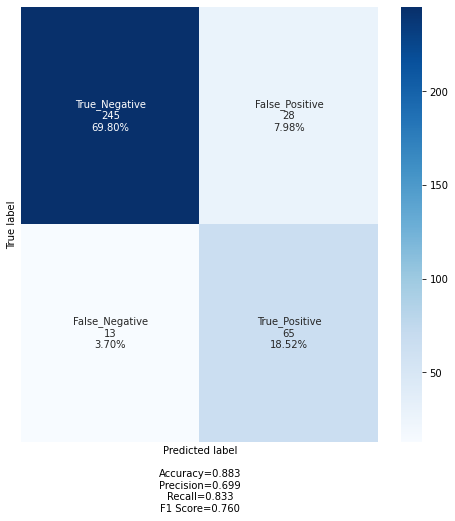

In [74]:
ml_DT2, best_params = GridSearchOptimizer(ml_DT, 'ml_DT2', d_hiperparametros_DT, X_train, y_train, X_test, y_test, i_CV)

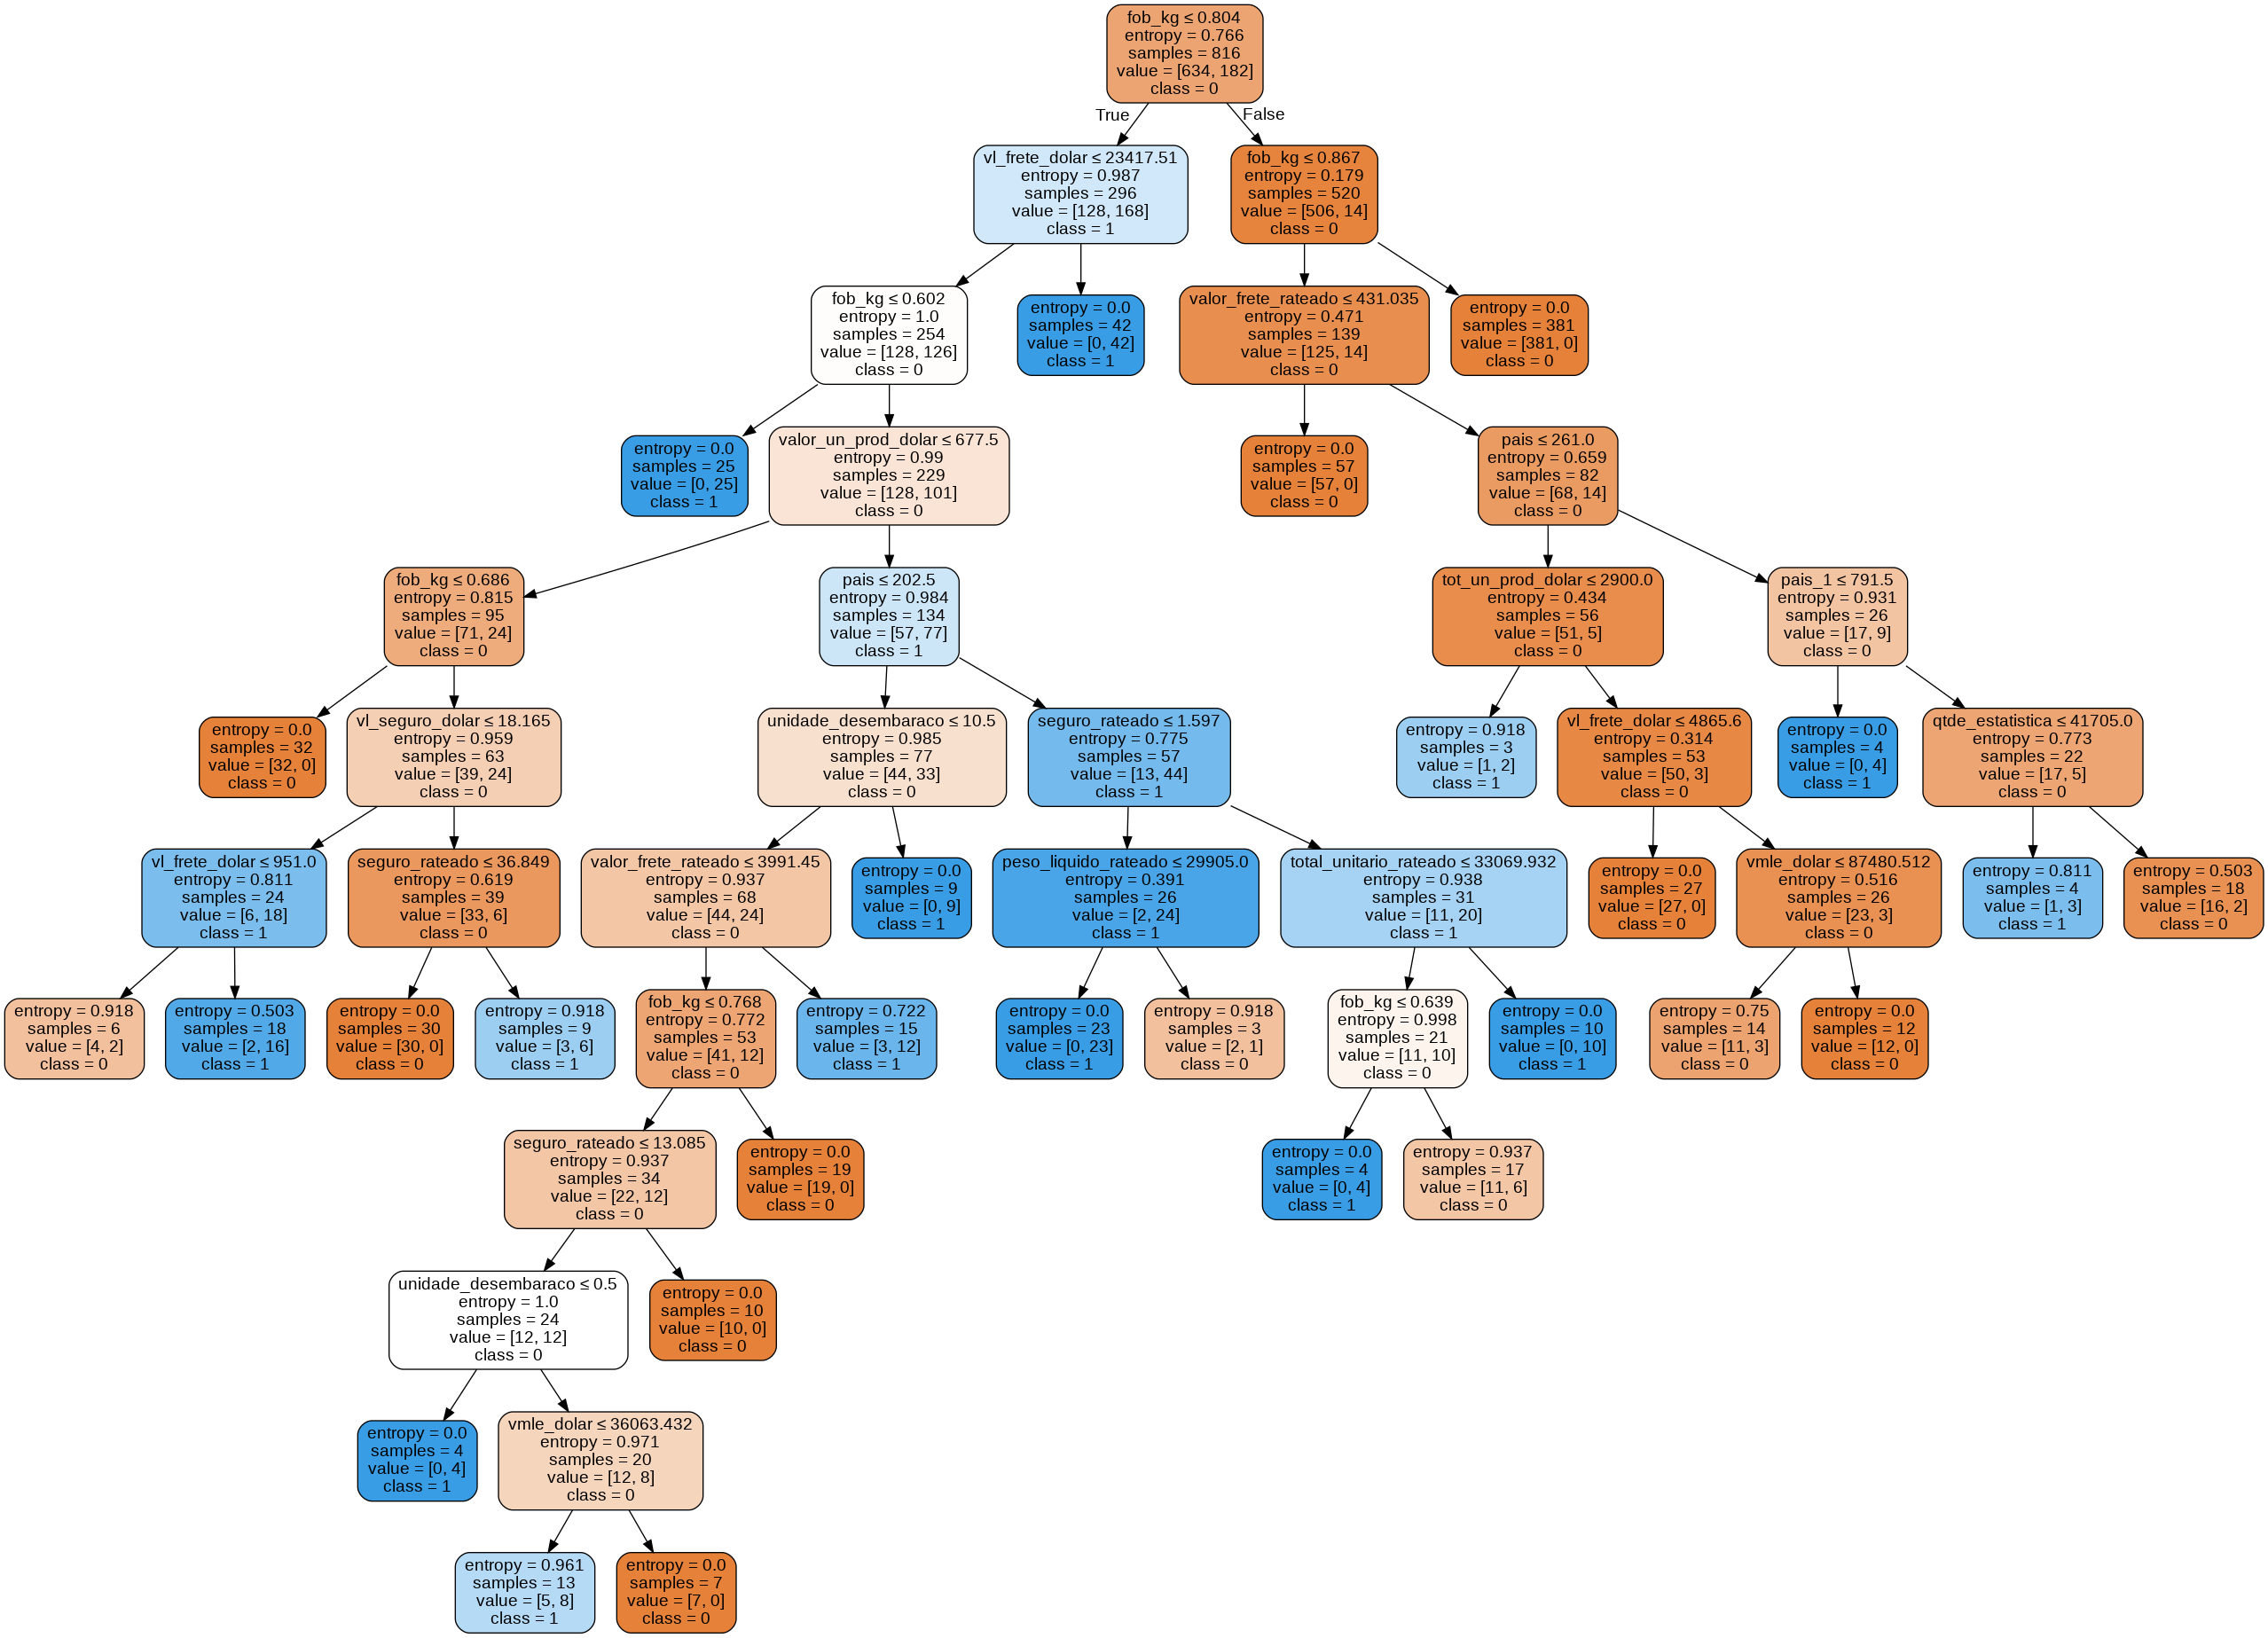

In [80]:
dot_data = StringIO()
export_graphviz(ml_DT2, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = X.columns, class_names = ['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('DecisionTree.png')
Image(graph.create_png())

Acurácia: 0.9316
Precision: 0.8
Revocação: 0.9231
F1 Score: 0.8571


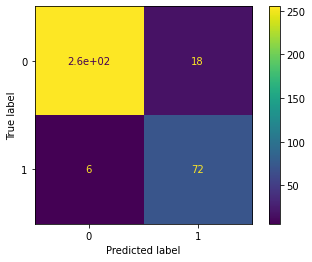

'TreeDecision.pdf'

In [83]:
ml_DT = DecisionTreeClassifier(criterion='entropy', max_depth= None, max_leaf_nodes=None, min_samples_leaf= 20, min_samples_split= 2, random_state=64)

train_model(ml_DT)

from sklearn import tree
import graphviz 

dot_data = tree.export_graphviz(ml_DT, 
                                out_file=None,
                                class_names=np.array(['Compatível','Incompatível']),
                                feature_names=X.columns)
graph = graphviz.Source(dot_data)
graph.render("TreeDecision")

In [84]:
ml_DT_a_scores_CV = cross_val_score(ml_DT, X_train, y_train, cv = 10)
print(f'Média das Acurácias calculadas pelo CV....: {100*round(ml_DT_a_scores_CV.mean(),4)}')
print(f'std médio das Acurácias calculadas pelo CV: {100*round(ml_DT_a_scores_CV.std(),4)}')
ml_DT_a_scores_CV

Média das Acurácias calculadas pelo CV....: 88.84
std médio das Acurácias calculadas pelo CV: 3.46


array([0.8902439 , 0.93902439, 0.8902439 , 0.8902439 , 0.84146341,
       0.91463415, 0.9382716 , 0.82716049, 0.87654321, 0.87654321])